In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import random
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# ---------------- Fitness Function ----------------
def svm_fitness(C, gamma):
    model = SVC(C=C, gamma=gamma)
    accuracy = cross_val_score(model, X, y, cv=5).mean()
    return accuracy

# ---------------- Genetic Algorithm Parameters ----------------
POPULATION_SIZE = 20
GENERATIONS = 30
MUTATION_STD = 0.1

# Initialize random population of hyperparameters (C and gamma)
def initialize_population(size):
    population = []
    for _ in range(size):
        C = random.uniform(0.01, 100)
        gamma = random.uniform(0.0001, 1)
        population.append((C, gamma))
    return population

# Tournament selection
def tournament_selection(population, fitnesses, k=3):
    selected = random.sample(list(zip(population, fitnesses)), k)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0]

# Blend crossover
def blend_crossover(parent1, parent2, alpha=0.5):
    C1 = alpha * parent1[0] + (1 - alpha) * parent2[0]
    gamma1 = alpha * parent1[1] + (1 - alpha) * parent2[1]
    C2 = alpha * parent2[0] + (1 - alpha) * parent1[0]
    gamma2 = alpha * parent2[1] + (1 - alpha) * parent1[1]
    return (C1, gamma1), (C2, gamma2)

# Gaussian mutation
def gaussian_mutation(individual, std=MUTATION_STD):
    C = max(individual[0] + random.gauss(0, std), 0.0001)
    gamma = max(individual[1] + random.gauss(0, std), 0.0001)
    return (C, gamma)

# Evaluate population
def evaluate_population(population):
    fitnesses = [svm_fitness(ind[0], ind[1]) for ind in population]
    return fitnesses

# Calculate population diversity
def calculate_diversity(population):
    C_values = [ind[0] for ind in population]
    gamma_values = [ind[1] for ind in population]
    return np.std(C_values) + np.std(gamma_values)

# ---------------- Fuzzy Logic Control System ----------------

# Define fuzzy inputs and outputs
diversity = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'diversity')
improvement = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'improvement')
mutation_rate = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'mutation_rate')
crossover_rate = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'crossover_rate')

# Membership functions for diversity
diversity['low'] = fuzz.trimf(diversity.universe, [0, 0, 0.5])
diversity['high'] = fuzz.trimf(diversity.universe, [0.5, 1, 1])

# Membership functions for improvement
improvement['low'] = fuzz.trimf(improvement.universe, [0, 0, 0.5])
improvement['high'] = fuzz.trimf(improvement.universe, [0.5, 1, 1])

# Membership functions for mutation rate
mutation_rate['low'] = fuzz.trimf(mutation_rate.universe, [0, 0, 0.5])
mutation_rate['high'] = fuzz.trimf(mutation_rate.universe, [0.5, 1, 1])

# Membership functions for crossover rate
crossover_rate['low'] = fuzz.trimf(crossover_rate.universe, [0, 0, 0.5])
crossover_rate['high'] = fuzz.trimf(crossover_rate.universe, [0.5, 1, 1])

# Fuzzy rules
rule1 = ctrl.Rule(diversity['low'] & improvement['low'], (mutation_rate['high'], crossover_rate['low']))
rule2 = ctrl.Rule(diversity['high'] & improvement['high'], (mutation_rate['low'], crossover_rate['high']))
rule3 = ctrl.Rule(diversity['low'] & improvement['high'], (mutation_rate['low'], crossover_rate['low']))
rule4 = ctrl.Rule(diversity['high'] & improvement['low'], (mutation_rate['high'], crossover_rate['high']))

# Create and simulate the control system
fuzzy_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
fuzzy_system = ctrl.ControlSystemSimulation(fuzzy_ctrl)

# ---------------- Main Genetic Algorithm ----------------

def genetic_algorithm():
    population = initialize_population(POPULATION_SIZE)
    best_solution = None
    best_fitness = 0
    prev_best_fitness = 0

    # Track fitness, C, and gamma over generations
    fitness_history = []
    C_history = []
    gamma_history = []

    for generation in range(GENERATIONS):
        fitnesses = evaluate_population(population)
        diversity_val = calculate_diversity(population)
        best_gen_fitness = max(fitnesses)
        improvement_val = max(0, best_gen_fitness - prev_best_fitness)

        # Fuzzy system input
        fuzzy_system.input['diversity'] = diversity_val
        fuzzy_system.input['improvement'] = improvement_val
        fuzzy_system.compute()

        mut_rate = fuzzy_system.output['mutation_rate']
        cross_rate = fuzzy_system.output['crossover_rate']

        # Select next generation
        new_population = []
        for _ in range(POPULATION_SIZE // 2):
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)

            if random.random() < cross_rate:
                offspring1, offspring2 = blend_crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1, parent2

            if random.random() < mut_rate:
                offspring1 = gaussian_mutation(offspring1)
                offspring2 = gaussian_mutation(offspring2)

            new_population.extend([offspring1, offspring2])

        population = new_population
        prev_best_fitness = best_gen_fitness

        # Track the best solution
        if best_gen_fitness > best_fitness:
            best_fitness = best_gen_fitness
            best_solution = population[np.argmax(fitnesses)]

        # Store data for visualization
        fitness_history.append(best_fitness)
        C_history.append(best_solution[0])
        gamma_history.append(best_solution[1])

        print(f"Generation {generation}: Best Fitness = {best_fitness:.4f}, Mutation Rate = {mut_rate:.2f}, Crossover Rate = {cross_rate:.2f}")

    return best_solution, best_fitness, fitness_history, C_history, gamma_history

# Run the Genetic Algorithm
best_params, best_score, fitness_history, C_history, gamma_history = genetic_algorithm()
print(f"\nBest Hyperparameters: C = {best_params[0]:.4f}, Gamma = {best_params[1]:.4f}")
print(f"Best Cross-Validation Score: {best_score:.4f}")



Generation 0: Best Fitness = 0.9800, Mutation Rate = 0.17, Crossover Rate = 0.83
Generation 1: Best Fitness = 0.9800, Mutation Rate = 0.83, Crossover Rate = 0.83
Generation 2: Best Fitness = 0.9800, Mutation Rate = 0.83, Crossover Rate = 0.83
Generation 3: Best Fitness = 0.9800, Mutation Rate = 0.83, Crossover Rate = 0.83
Generation 4: Best Fitness = 0.9800, Mutation Rate = 0.82, Crossover Rate = 0.82
Generation 5: Best Fitness = 0.9800, Mutation Rate = 0.76, Crossover Rate = 0.76
Generation 6: Best Fitness = 0.9800, Mutation Rate = 0.76, Crossover Rate = 0.24
Generation 7: Best Fitness = 0.9800, Mutation Rate = 0.76, Crossover Rate = 0.76
Generation 8: Best Fitness = 0.9800, Mutation Rate = 0.75, Crossover Rate = 0.75
Generation 9: Best Fitness = 0.9800, Mutation Rate = 0.78, Crossover Rate = 0.22
Generation 10: Best Fitness = 0.9800, Mutation Rate = 0.77, Crossover Rate = 0.23
Generation 11: Best Fitness = 0.9800, Mutation Rate = 0.77, Crossover Rate = 0.23
Generation 12: Best Fitnes

Okay, let's break down the first code snippet which uses a Genetic Algorithm to optimize the hyperparameters of an SVM classifier for the Iris dataset, with Fuzzy Logic controlling the mutation and crossover rates.

1. Initialization:

Import necessary libraries: numpy, sklearn, random, matplotlib, and skfuzzy.
Load the Iris dataset: datasets.load_iris() loads the dataset, and X and y store the features and target labels, respectively.
Define the fitness function (svm_fitness): This function takes hyperparameters (C and gamma) as input, creates an SVM model with those parameters, and returns the model's cross-validation accuracy. This accuracy is used to evaluate the "fitness" of a set of hyperparameters.
Set Genetic Algorithm parameters: POPULATION_SIZE, GENERATIONS, and MUTATION_STD control the size of the population, number of iterations, and mutation rate, respectively.
Initialize the population (initialize_population): This function creates a random population of hyperparameter sets (C and gamma values) within specified ranges.
2. Genetic Algorithm Operations:

Tournament selection (tournament_selection): This function randomly selects a few individuals (hyperparameter sets) and returns the one with the highest fitness (accuracy). This simulates "survival of the fittest."
Blend crossover (blend_crossover): This function takes two parents (hyperparameter sets) and creates two offspring by blending their C and gamma values using a weighted average. This helps explore new areas of the hyperparameter space.
Gaussian mutation (gaussian_mutation): This function introduces random changes to an individual's hyperparameters by adding noise drawn from a Gaussian distribution. This helps maintain diversity in the population and prevents premature convergence.
Evaluate population (evaluate_population): This function calculates the fitness (accuracy) of each individual in the population using the svm_fitness function.
Calculate diversity (calculate_diversity): This function measures the diversity of the population by calculating the standard deviation of C and gamma values. Diversity is important to avoid getting stuck in local optima.
3. Fuzzy Logic Control:

Define fuzzy inputs and outputs: Using skfuzzy, we define fuzzy variables for diversity, improvement, mutation rate, and crossover rate. These variables represent linguistic terms like "low" and "high."
Define membership functions: We assign membership functions to each fuzzy variable to define the degree to which a value belongs to a particular linguistic term. For example, a diversity value of 0.2 might have a high membership in the "low" category and a low membership in the "high" category.
Define fuzzy rules: We create rules that relate the inputs to the outputs. For example, "If diversity is low and improvement is low, then increase mutation rate and decrease crossover rate."
Create and simulate the control system: We use skfuzzy to create a fuzzy logic controller and simulate its behavior. The controller takes diversity and improvement as inputs and outputs mutation and crossover rates.
4. Main Genetic Algorithm Loop:

The genetic_algorithm function runs the main loop of the algorithm:
It initializes the population.
It iterates for a fixed number of generations.
In each generation, it evaluates the population, calculates diversity and improvement, uses the fuzzy system to adjust mutation and crossover rates, selects parents, performs crossover and mutation, and updates the population.
It tracks the best solution found so far.
Finally, it returns the best hyperparameters, best fitness, and data for visualization.
5. Visualization (not included in the provided code but often done):

The code could be extended to visualize the fitness over generations, the evolution of hyperparameters, and the fuzzy control surface. This helps understand how the algorithm is working and the impact of fuzzy logic.
In summary, this code uses a Genetic Algorithm to find the optimal hyperparameters for an SVM classifier. The algorithm is enhanced with Fuzzy Logic to dynamically adjust the mutation and crossover rates based on the population's diversity and improvement over time. This adaptive approach can lead to better solutions and faster convergence. I hope this explanation is helpful for your viva! Good luck!

In [ ]:
pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 13.3 MB/s eta 0:00:00


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.4183 - loss: 1.0617 - val_accuracy: 0.6000 - val_loss: 1.0520
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6231 - loss: 1.0297 - val_accuracy: 0.6000 - val_loss: 1.0251
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6723 - loss: 0.9804 - val_accuracy: 0.6000 - val_loss: 0.9948
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6627 - loss: 0.9653 - val_accuracy: 0.6000 - val_loss: 0.9620
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6762 - loss: 0.9355 - val_accuracy: 0.6000 - val_loss: 0.9277
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6877 - loss: 0.8738 - val_accuracy: 0.6000 - val_loss: 0.8924
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6825 - loss: 0.8298 - val_accuracy: 0.6000 - val_loss: 0.8595
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6533 - loss: 0.8470 - val_accuracy: 0.6000 - val_loss

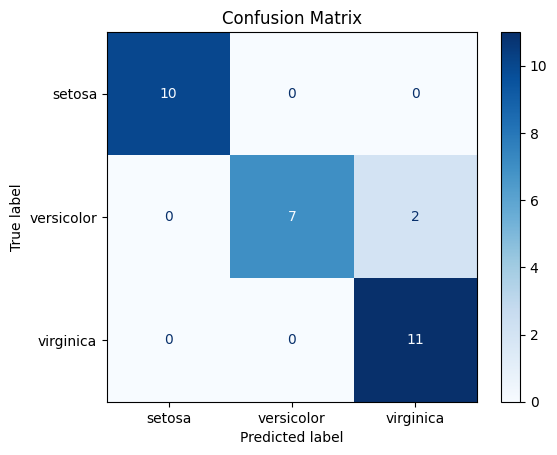

[[ 2.4052609e-02  2.2296086e-01  4.4324119e-02]
 [-4.3452669e-02 -3.5911780e-05  2.9463449e-01]
 [ 6.6876769e-02  7.4132189e-02  8.1968717e-02]
 [ 1.6884251e-01  3.4659922e-02  6.3562103e-02]]
[[ 0.0453182  -0.19342628  0.00196619]
 [-0.00364938 -0.01788266 -0.26470923]
 [ 0.1002515  -0.09032373 -0.08667346]
 [ 0.22637694 -0.09497973  0.09167435]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ---------------- Load and Preprocess Data ----------------

np.random.seed(0)

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

y_one_hot = []
for i in y:
  if i == 0:
    y_one_hot.append([1,0,0])
  elif i == 1:
    y_one_hot.append([0,1,0])
  else:
    y_one_hot.append([0,0,1])
y_one_hot = np.array(y_one_hot)


# Normalize the input data
X_min, X_max = X.min(axis=0), X.max(axis=0)
X_norm = (X - X_min) / (X_max - X_min)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_one_hot, test_size=0.2, random_state=42)

# ---------------- Define Adaptive Fuzzy Membership Functions ----------------

class AdaptiveFuzzyLayer(layers.Layer):
    def __init__(self, num_mfs, input_dim):
        super(AdaptiveFuzzyLayer, self).__init__()
        self.num_mfs = num_mfs
        self.input_dim = input_dim
        # Initialize means and sigmas as trainable parameters for each feature
        self.means = self.add_weight(name='means', shape=(input_dim, num_mfs), initializer='uniform', trainable=True)
        self.sigmas = self.add_weight(name='sigmas', shape=(input_dim, num_mfs), initializer='uniform', trainable=True)

    def call(self, inputs):
        # Calculate Gaussian membership values for each feature and each membership function
        expanded_inputs = tf.expand_dims(inputs, -1)  # Shape: (batch_size, input_dim, 1)
        gaussians = tf.exp(-tf.square(expanded_inputs - self.means) / (2 * tf.square(self.sigmas)))
        return gaussians

# ---------------- Define Neuro-Fuzzy Model ----------------

def create_neuro_fuzzy_model(num_mfs, input_dim, num_classes):
    input_layer = layers.Input(shape=(input_dim,))
    fuzzy_layer = AdaptiveFuzzyLayer(num_mfs, input_dim)(input_layer)  # Fuzzification layer
    flatten_layer = layers.Flatten()(fuzzy_layer)
    hidden_layer = layers.Dense(50, activation='relu')(flatten_layer)
    output_layer = layers.Dense(num_classes, activation='softmax')(hidden_layer)  # For multi-class classification
    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Define model parameters
num_mfs = 3
input_dim = X.shape[1]
num_classes = y_one_hot.shape[1]

# Create the Neuro-Fuzzy model
model = create_neuro_fuzzy_model(num_mfs, input_dim, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ---------------- Train the Model ----------------

history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test))

# ---------------- Evaluate the Model ----------------

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# ---------------- Predict and Plot Confusion Matrix ----------------

# Predict using the trained model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()




learned_means = model.layers[1].means.numpy()
learned_sigmas = model.layers[1].sigmas.numpy()

print(learned_means)
print(learned_sigmas)

Okay, let's break down the second code snippet which builds and trains a Neuro-Fuzzy model using TensorFlow/Keras for the Iris dataset classification.

1. Initialization and Data Preprocessing:

Import libraries: numpy, matplotlib, tensorflow, sklearn, and pandas.
Load the Iris dataset: datasets.load_iris() is used to load the dataset, with X and y storing features and target labels, respectively.
One-hot encode target labels: The target labels (y) are converted into one-hot encoded format using manual loops, making them suitable for multi-class classification with the neural network.
Normalize input data: The input features (X) are normalized to a range of 0 to 1 using min-max scaling. This helps improve the performance of the model.
Split data into training and testing sets: train_test_split() is used to divide the data into training and testing sets, with 80% for training and 20% for testing.
2. Define Adaptive Fuzzy Membership Functions:

AdaptiveFuzzyLayer class: This custom Keras layer implements the fuzzification step of the Neuro-Fuzzy model.
It takes the number of membership functions (num_mfs) and input dimension (input_dim) as parameters.
It defines trainable weights for the means and standard deviations (sigmas) of Gaussian membership functions for each input feature.
The call method calculates the membership values for each input data point using Gaussian functions based on the learned means and sigmas.
This layer allows the fuzzy membership functions to adapt during training, improving the model's ability to capture complex relationships in the data.
3. Define Neuro-Fuzzy Model:

create_neuro_fuzzy_model function: This function defines the structure of the Neuro-Fuzzy model using Keras' functional API.
It takes the number of membership functions, input dimension, and number of classes as parameters.
It creates an input layer, followed by the AdaptiveFuzzyLayer for fuzzification.
The output of the fuzzy layer is flattened and passed through a hidden layer with ReLU activation.
Finally, an output layer with softmax activation is used for multi-class classification.
This function creates a model that combines fuzzy logic with a neural network architecture.
4. Compile and Train the Model:

The model is compiled with the Adam optimizer, categorical cross-entropy loss function (suitable for multi-class classification), and accuracy as the evaluation metric.
The model is trained using the fit method, providing the training data, number of epochs, and validation data.
5. Evaluate and Predict:

Evaluate the model: The evaluate method is used to assess the model's performance on the test data, calculating the test loss and accuracy.
Predict and plot confusion matrix: The model is used to predict the classes for the test data. The predictions are compared with the true labels to generate a confusion matrix, which visualizes the model's performance in classifying different Iris species. The confusion matrix is displayed using ConfusionMatrixDisplay from sklearn.metrics.
6. Extract Learned Parameters (optional):

The code also includes lines to extract the learned means and sigmas of the Gaussian membership functions from the AdaptiveFuzzyLayer. This information can be used to understand how the fuzzy system has adapted to the data.
In summary, this code demonstrates how to build and train a Neuro-Fuzzy model for Iris classification using TensorFlow/Keras. It leverages adaptive fuzzy membership functions to enhance the model's learning capabilities. The code also includes steps for evaluating the model's performance and visualizing its predictions using a confusion matrix. I hope this explanation is helpful for your viva! Good luck!

Sources
programtown.com/machine-learning-part-7-deep-learning-and-neural-networks/